# Assignment 1

Due Friday 5th August 23:59

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# comment only in test branch :D

In [5]:
houses = pd.read_csv('data.csv')
houses.head()

,Unnamed: 0,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
0,1,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,2,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,3,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,4,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,5,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes


Remove the unnamed column, as it only counts the rows number.

In [6]:
houses = houses.drop(houses.columns[[0]], axis=1) 
houses

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,289000,0.38,32,24200,2310,61,5,1,2.5,11,hot water/steam,gas,public/commercial,No,No,No
1724,285000,0.94,37,36200,2564,61,4,1,2.5,11,hot water/steam,gas,public/commercial,No,No,No
1725,194900,0.39,9,20400,1099,51,2,0,1.0,3,hot air,gas,public/commercial,No,No,No
1726,125000,0.24,48,16800,1225,51,3,1,1.0,7,hot air,gas,public/commercial,No,No,No


There are 1728 rows with mostly int and categorical data types. There are no missing values from the dataset.

In [4]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            1728 non-null   int64  
 1   lotSize          1728 non-null   float64
 2   age              1728 non-null   int64  
 3   landValue        1728 non-null   int64  
 4   livingArea       1728 non-null   int64  
 5   pctCollege       1728 non-null   int64  
 6   bedrooms         1728 non-null   int64  
 7   fireplaces       1728 non-null   int64  
 8   bathrooms        1728 non-null   float64
 9   rooms            1728 non-null   int64  
 10  heating          1728 non-null   object 
 11  fuel             1728 non-null   object 
 12  sewer            1728 non-null   object 
 13  waterfront       1728 non-null   object 
 14  newConstruction  1728 non-null   object 
 15  centralAir       1728 non-null   object 
dtypes: float64(2), int64(8), object(6)
memory usage: 216.1+ KB


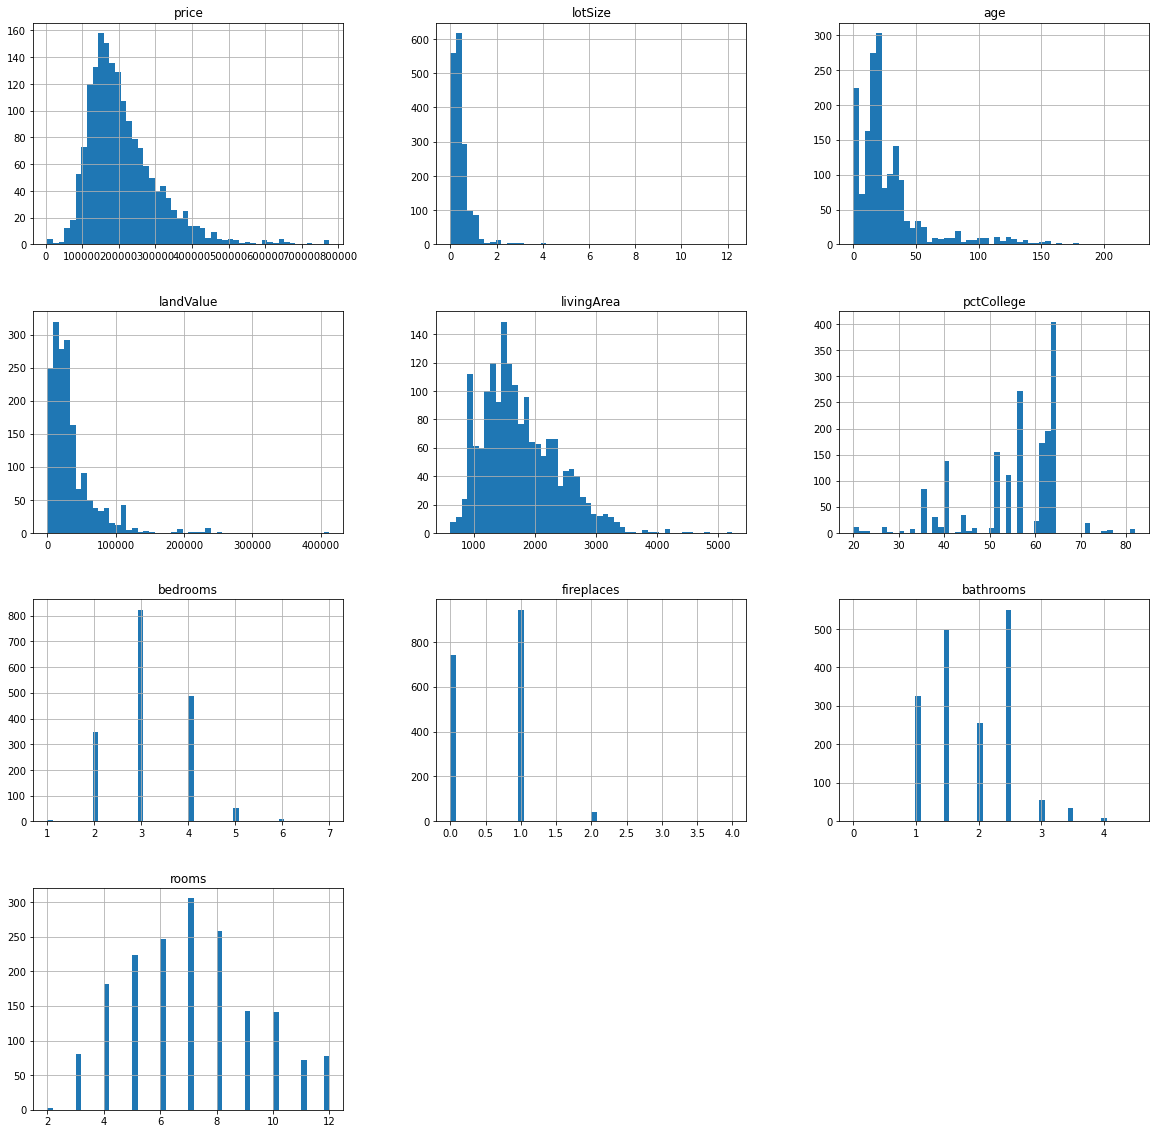

In [6]:
houses.hist(bins = 50, figsize = (20,20))
fig = plt.gcf() 
fig.savefig('hist.pdf', bbox_inches = 'tight')

In [5]:
houses.describe()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,211966.705440,0.500214,27.916088,34557.187500,1754.975694,55.567708,3.154514,0.601852,1.900174,7.041667
std,98441.391015,0.698680,29.209988,35021.168056,619.935553,10.333581,0.817351,0.556102,0.658352,2.316453
min,5000.000000,0.000000,0.000000,200.000000,616.000000,20.000000,1.000000,0.000000,0.000000,2.000000
25%,145000.000000,0.170000,13.000000,15100.000000,1300.000000,52.000000,3.000000,0.000000,1.500000,5.000000
50%,189900.000000,0.370000,19.000000,25000.000000,1634.500000,57.000000,3.000000,1.000000,2.000000,7.000000
75%,259000.000000,0.540000,34.000000,40200.000000,2137.750000,64.000000,4.000000,1.000000,2.500000,8.250000
max,775000.000000,12.200000,225.000000,412600.000000,5228.000000,82.000000,7.000000,4.000000,4.500000,12.000000


In [10]:
def summary(df):
    print(df.info())
    print(df.describe())
summary(houses)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            1728 non-null   int64  
 1   lotSize          1728 non-null   float64
 2   age              1728 non-null   int64  
 3   landValue        1728 non-null   int64  
 4   livingArea       1728 non-null   int64  
 5   pctCollege       1728 non-null   int64  
 6   bedrooms         1728 non-null   int64  
 7   fireplaces       1728 non-null   int64  
 8   bathrooms        1728 non-null   float64
 9   rooms            1728 non-null   int64  
 10  heating          1728 non-null   object 
 11  fuel             1728 non-null   object 
 12  sewer            1728 non-null   object 
 13  waterfront       1728 non-null   object 
 14  newConstruction  1728 non-null   object 
 15  centralAir       1728 non-null   object 
dtypes: float64(2), int64(8), object(6)
memory usage: 216.1+ KB
N

In [7]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(houses, 
                                       test_size = 0.2,
                                      random_state = 0)

In [9]:
train_set.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
1649,153000,0.11,16,2900,1480,40,2,0,2.5,4,hot air,gas,public/commercial,No,No,No
1465,223000,0.33,18,27000,1360,40,3,1,1.5,8,electric,electric,public/commercial,No,No,No
361,178500,1.00,12,32000,1952,71,3,2,2.0,9,hot air,oil,septic,No,No,No
315,168500,0.44,34,31800,1586,64,3,1,1.5,7,hot air,gas,public/commercial,No,No,No
1372,167500,0.16,18,15100,1492,40,3,0,2.5,6,electric,electric,public/commercial,No,No,No


In [10]:
test_set.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
1318,229900,0.44,7,24200,1328,64,3,1,2.5,8,hot air,gas,public/commercial,No,No,No
124,158000,0.52,0,4400,2098,44,3,0,2.0,7,hot air,gas,septic,No,Yes,Yes
648,367500,0.27,2,78200,2205,57,3,1,2.5,10,hot air,gas,public/commercial,No,No,Yes
249,128850,0.92,16,5500,824,45,3,0,1.5,5,electric,electric,septic,No,No,No
1599,290000,0.61,34,32300,2728,64,4,1,2.5,10,hot water/steam,gas,public/commercial,No,No,No


# Discover and visualize data

In [15]:
houses = train_set.copy()

In [70]:
corr_matrix = houses.corr()
corr_matrix["price"].sort_values(ascending = False)

price         1.000000
livingArea    0.723380
bathrooms     0.600116
landValue     0.594116
rooms         0.537491
bedrooms      0.413254
fireplaces    0.389420
pctCollege    0.216864
lotSize       0.134894
age          -0.203958
Name: price, dtype: float64

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

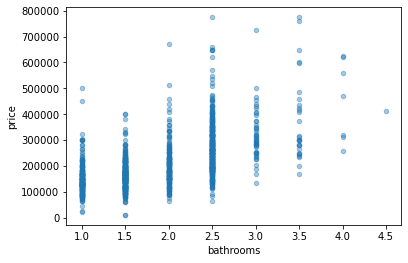

In [28]:
houses.plot(kind = "scatter", x = "bathrooms", y = "price",
           alpha = 0.4)

<AxesSubplot:xlabel='landValue', ylabel='livingArea'>

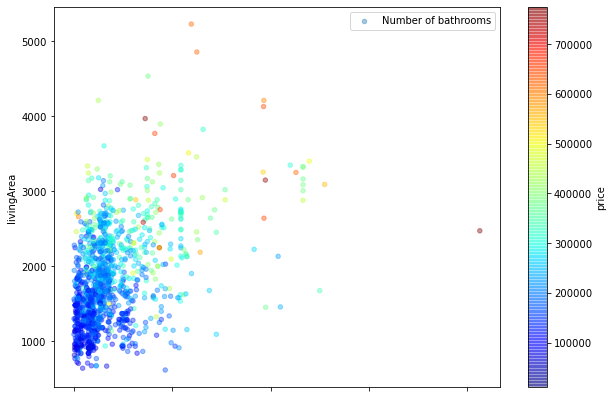

In [66]:
houses.plot(kind = "scatter", x = "landValue", y = "livingArea",
           alpha = 0.4,
           label = "Number of bathrooms",
           figsize = (10,7),
           c = "price", 
           cmap = plt.get_cmap("jet"))

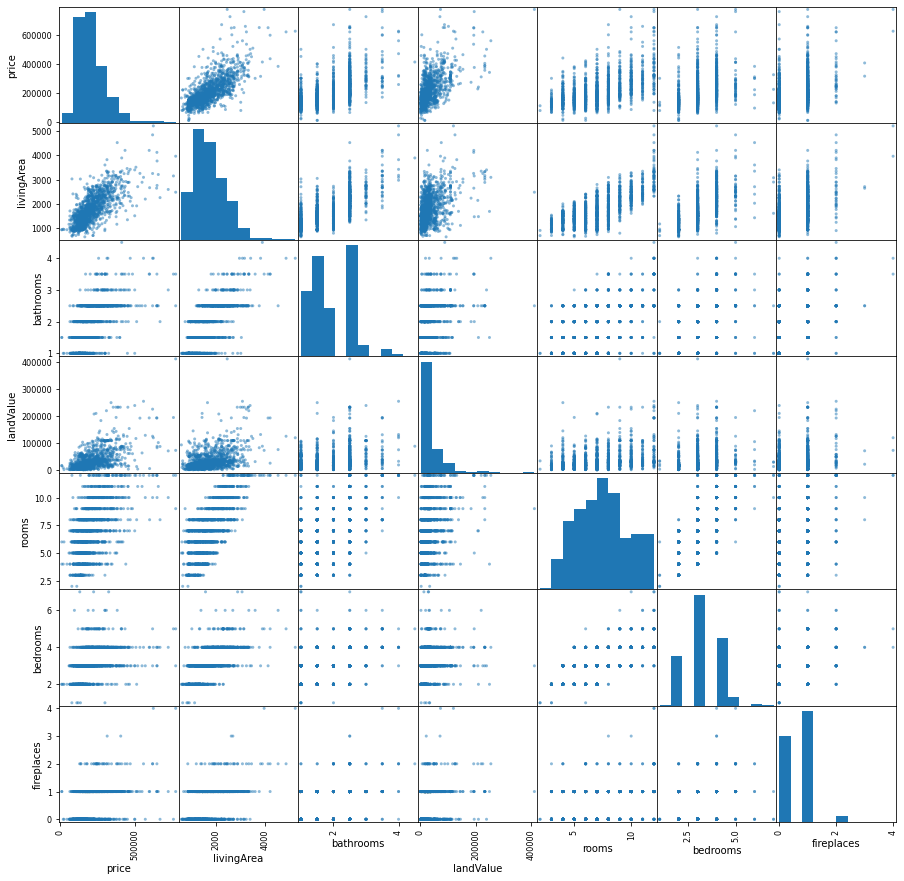

In [76]:
from pandas.plotting import scatter_matrix

attributes = ["price", "livingArea", "bathrooms", 
              "landValue", "rooms", "bedrooms", 
              "fireplaces"]
scatter_matrix(houses[attributes], figsize = (15,15))
plt.show()

## Prepare the data for machine learning algorithms

Separate the predictors and the labels since we don't
necessarily want to apply the same transformations
to the predictors and the target values.

In [78]:
X_train = train_set.drop("price", axis = 1) # drop labels for the training set
y_train = train_set["price"].copy()  # save the labels

In [81]:
X_train.head(5)

,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
1649,0.11,16,2900,1480,40,2,0,2.5,4,hot air,gas,public/commercial,No,No,No
1465,0.33,18,27000,1360,40,3,1,1.5,8,electric,electric,public/commercial,No,No,No
361,1.00,12,32000,1952,71,3,2,2.0,9,hot air,oil,septic,No,No,No
315,0.44,34,31800,1586,64,3,1,1.5,7,hot air,gas,public/commercial,No,No,No
1372,0.16,18,15100,1492,40,3,0,2.5,6,electric,electric,public/commercial,No,No,No


In [82]:
y_train.head(5)

1649    153000
1465    223000
361     178500
315     168500
1372    167500
Name: price, dtype: int64

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [93]:
data_transform_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # replace missing values with median
    ('std_scaler', StandardScaler()) #standardizes data
])
data_transform_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('std_scaler', StandardScaler())])

In [91]:
# only numerical allowed?
X_train_prepared = data_transform_pipeline.fit_transform(X_train)

ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: 'hot air'

In [1]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

NameError: name 'X_train_prepared' is not defined

In [4]:
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]
some_data_prepared = data_transform_pipeline.transform(some_data)

print("predictions:", lin_reg.predict(some_data_prepared))


NameError: name 'X_train' is not defined